In [1]:
import regression as r

In [2]:
icgem_data_gravity_ell = r.hm.load_icgem_gdf("data/data-0/gravity_ell_GOCO06s_b879cfa8a540bb2270679488088ac44ae6bb97a88e9a684d371b9bf791af0ae8.gdf")
icgem_data_topography_grd = r.hm.load_icgem_gdf("data/data-0/topography_grd_etopo1-2250_e7099801d365e5743ae72126f13202d19064ee81d61ff961a85b58f9ace75454.gdf")

In [3]:
#icgem_data_topography_grd

In [4]:
#icgem_data_gravity_ell

In [5]:
data = r.xr.merge(
    [icgem_data_gravity_ell.rename({"gravity_ell":"gravity"}), icgem_data_topography_grd.rename({"topography_grd":"topography"})
    ])

#data

In [6]:
# gravidade normal elipsoidal a 10km
gamma = r.bl.WGS84.normal_gravity(data.latitude, 10000)

disturbance = data.gravity - gamma

bouguer_corr = r.hm.bouguer_correction(data.topography)
data["dg_bouguer"] = disturbance - bouguer_corr

data

<xarray.Dataset> Size: 2MB
Dimensions:          (latitude: 181, longitude: 361)
Coordinates:
  * latitude         (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * longitude        (longitude) float64 3kB -180.0 -179.0 ... 179.0 180.0
Data variables:
    gravity          (latitude, longitude) float64 523kB 9.801e+05 ... 9.802e+05
    height_over_ell  (latitude, longitude) float64 523kB 1e+04 1e+04 ... 1e+04
    topography       (latitude, longitude) float64 523kB 2.745e+03 ... -4.228...
    dg_bouguer       (latitude, longitude) float64 523kB -340.8 -340.8 ... 298.8
Attributes: (12/35)
    generating_institute:  gfz-potsdam
    generating_date:       2026/02/02
    product_type:          gravity_field
    body:                  earth
    modelname:             GOCO06s
    max_used_degree:       250
    ...                    ...
    maxvalue:              9.8015408E+05 mgal
    minvalue:              9.7486690E+05 mgal
    signal_wrms:           1.5471939E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

In [7]:
topo = data.topography.values.ravel()
dg = data.dg_bouguer.values.ravel()

mask = ~r.np.isnan(topo) & ~r.np.isnan(dg)
h = topo[mask]
d = dg[mask]

In [8]:
region = r.vd.get_region((data.longitude.values, data.latitude.values)) # usar .values para passar paena sos valores numéricos

lon_grid, lat_grid = r.vd.grid_coordinates(
    region = region,
    shape = data.topography.shape,
    meshgrid = True
)

lon_all = lon_grid.ravel()
lat_all = lat_grid.ravel()

mask = ~r.np.isnan(lon_all) & ~r.np.isnan(lat_all)
lon, lat = lon_all[mask], lat_all[mask]

In [9]:
window_coordinates, indices = r.bd.rolling_window_spherical(
    coordinates = (lon, lat),
    window_size = 3.0, # janelas de 3 graus
    overlap = 0.5
)

In [10]:
resultados = []
cont = 0

for i, idx_window in enumerate(indices):
    h_window = h[idx_window]
    
    if len(h_window) == 0:
        cont += 1
        print(f' Window {i} is empty. Coordinates: Lon {window_coordinates[0][i]:.2f}, Lat{window_coordinates[1][i]:.2f}')
        continue # vai para a próxima janela, próximo 'i'
    
    d_window = d[idx_window]
    p_window = r.robust_regression(h_window, d_window)

    n_points_ocean = r.np.sum(h_window < 0)
    n_points_continent = r.np.sum(h_window >=0)

    resultados.append({
        'original-idx': i,
        'longitude': window_coordinates[0][i],
        'latitude': window_coordinates[1][i],
        'a_o': p_window[0],
        'a_c':p_window[1],
        'b': p_window[2],
        'points':len(idx_window[0]),
        'ocean-points': n_points_ocean,
        'continent_points': n_points_continent
    })

print(f'Há {cont} janelas sem valores registrados de topografia.')

Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de topografia com tamanho menor que 20
Vetor de t

In [30]:
df_windows = r.pd.DataFrame(resultados)
df_windows.to_csv('df_windows.csv')
#df_windows

In [31]:
df_windows_mixed_coefs = r.pd.DataFrame(resultados).dropna(subset = ['a_o', 'a_c', 'b'])
df_windows_mixed_coefs.to_csv('df_windows_mixed_coefs.csv')


df_windows_ocean = df_windows[df_windows['a_c'].isna()]
df_windows_ocean.to_csv('df_windows_ocean.csv')

df_windows_continent = df_windows[df_windows['a_o'].isna()]
df_windows_continent.to_csv('df_windows_continent.csv')

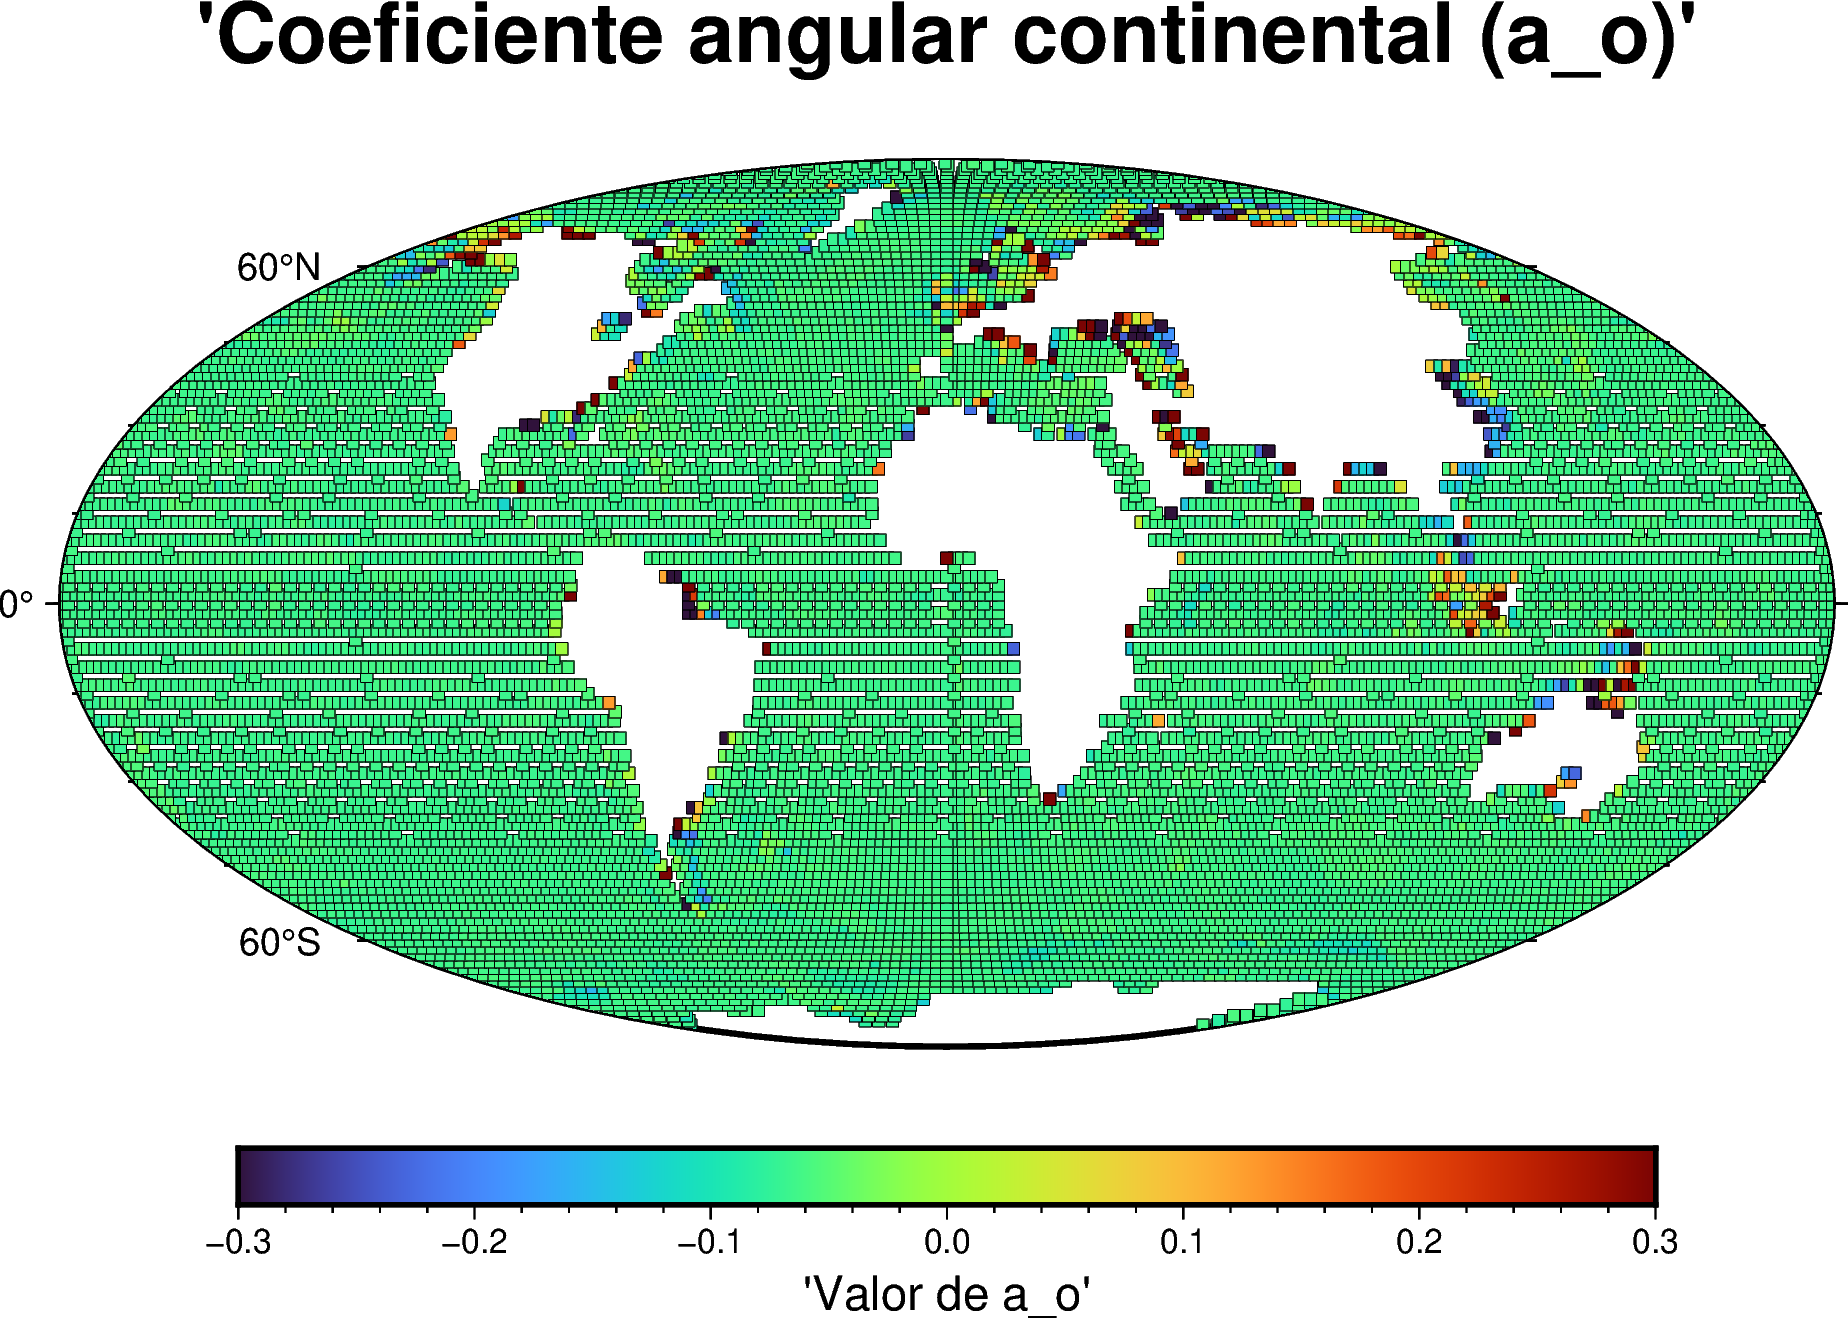

In [13]:
v_min = -0.3
v_max = 0.3
passo = 0.01 # Quanto menor o passo, mais suave a transição de cores

fig = r.pygmt.Figure()

# Criar a CPT com limites fixos
r.pygmt.makecpt(
    cmap='turbo', 
    series=[v_min, v_max, passo], 
    continuous=True,
    # Opcional: faz com que valores < -1 fiquem com a cor do mínimo 
    # e valores > 1 fiquem com a cor do máximo
    background=True 
)


fig.basemap(region = 'd', # 'd' = domain, global
            projection = 'W15c', # projeção de Robinson, mapa com 15cm, 'a': annotation, ativa coordenadas numéricas, 'f' de frame ticks, traços de régua
            frame = ["af", "WSne+t'Coeficiente angular continental (a_o)'"] # WSne refe explicitamente apenas W e S, os outros naão são escritos, +t é o título do mapa
           )

fig.coast(water = 'white') # shorelines = '1/0.5p,black', land = 'lightgray'


df_plot = df_windows.dropna(subset = ['a_o'])
fig.plot(
    x = df_plot.longitude,
    y = df_plot.latitude, 
    fill = df_plot.a_o, #montando um mapa, que é uma grade
    cmap = True,
    style = 's0.15c', # quero plotado quadrados de 0.25cm
    pen = '0.1p, black', # contorno do plot dos quadrados, nesse caso 
)

fig.colorbar(frame = "af+l'Valor de a_o'")

fig.savefig('mapa-coeficiente-continental.png', dpi = 300)

fig.show()

            

In [17]:
# janela especifica que quero acessar
i_wished_window = 18295
line_in_df = df_windows.loc[df_windows['original-idx'] == i_wished_window] # localizo original-idx

if not line_in_df.empty: # para caso a linha não esteja no df 
    lon = line_in_df['longitude'].values[0] # [0] para o pandas não bugar, ele ve values como filtro
    lat = line_in_df['latitude'].values[0]

    print(f'A janela {i_wished_window} tem coordenadas: Longitude {lon:.2f} e Latitude {lat:.2f}')

else:
    print(f'A janela não está no df e pode ter sido descartada ou está vazia')

line_in_df

A janela 18295 tem coordenadas: Longitude 331.25 e Latitude 84.00


,original-idx,longitude,latitude,a_o,a_c,b,points,ocean-points,continent_points
18295,18295,331.245508,84.0,-0.066705,-0.10474,23.818271,87,69,18


In [18]:
idx_current = indices[i_wished_window][0]

h_window_raw = h[idx_current]
d_window_raw = d[idx_current]

# crio uma lista com os índices de h_window_raw que colocam o array em ordem numérica ex: [28, 3, 87] é o que deicaria o array em ordem
idx_sort = r.np.argsort(h_window_raw)

h_window = h_window_raw[idx_sort]
d_window = d_window_raw[idx_sort]

p_window = r.robust_regression(h_window, d_window)
a_ocean_window, a_continent_window, intercept_window = p_window

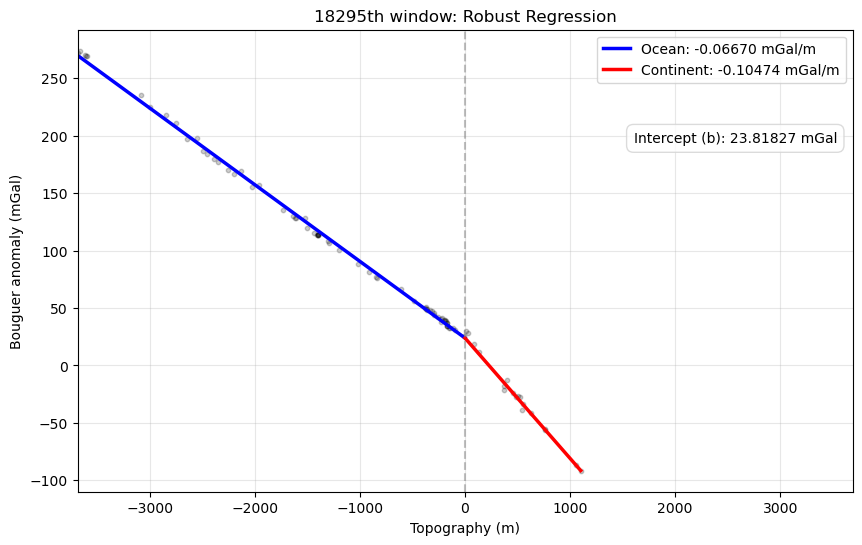

In [19]:
r.plot_window_regression(i_wished_window, h_window, d_window, a_ocean_window, a_continent_window, intercept_window)